In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Conv1D, Flatten,\
                                    Reshape, MaxPooling1D,\
                                    Dropout, Conv1DTranspose, UpSampling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import matplotlib
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
from pyfaidx import Fasta
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
import pandas as pd
import pyBigWig
import tqdm
from pyfaidx import Fasta
from subprocess import run, PIPE, Popen

2023-11-16 13:35:34.425889: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 13:35:35.542692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 13:35:36.285842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 13:35:36.285875: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 13:35:36.289388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
def encode_sequence(seq):
    
    d = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1], 
    'N' : [0.25, 0.25, 0.25, 0.25]}

    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')

In [3]:
data = pd.read_csv("~/psychScreen/Corces/Corces.txt", sep="\t", header=0)
data.head()

,chrom,start,stop,rDHS,Microglia,Oligodendrocytes,ExcitatoryNeurons,NigralNeurons,OPCs,Astrocytes,InhibitoryNeurons,nCells
0,chr1,181289,181639,EH38D4327525,0,0,0,0,0,0,0,0
1,chr1,191294,191644,EH38D4327540,0,1,0,1,1,1,1,5
2,chr1,267925,268171,EH38D4327544,0,1,1,0,1,1,1,5
3,chr1,586036,586264,EH38D4327554,0,1,1,0,1,1,1,5
4,chr1,605330,605668,EH38D4327560,0,0,1,0,0,0,0,1


In [4]:
cells = data.columns[4:-1].tolist()
y_class = data[cells].values

In [5]:
latent_dim = 256
# filters = 128
# kernel_size = 32
# layer_filters = [128, 128]

In [6]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

def kl_divergence_loss(inputs):
    mu, log_var = inputs
    outputs = -0.5 * (1 + log_var - tf.math.square(mu) - tf.math.exp(log_var))
    return(outputs)

In [7]:
from tensorflow.keras.optimizers import Adam
def vae1():
    l = 512
    img = Input(shape = (l, 4))
    encoder = img
    
    encoder = Conv1D(filters=256, 
                     name="conv",
               kernel_size=32,
               activation='relu',
               strides=1,
               padding='same')(encoder)
    
    encoder = MaxPooling1D(8)(encoder)
    
    encoder = Conv1D(filters=128,
               kernel_size=8,
               activation='relu',
               strides=1,
               padding='same')(encoder)
    
    encoder = MaxPooling1D(2)(encoder)
    shape = K.int_shape(encoder)
    
    encoder = Flatten()(encoder)
    encoder = Dense(1028)(encoder)
    encoder = Dense(512)(encoder)
    
    
    # Define output latent space
    z_mu = tf.keras.layers.Dense(latent_dim, name = 'z_mu')(encoder)
    z_log_var = tf.keras.layers.Dense(latent_dim, name = 'z_log_var')(encoder)
    z = tf.keras.layers.Lambda(sample_latent_features, name = 'latent_features')([z_mu, z_log_var])
    
    # Kullback-Leibler Divergence
    kl_div= tf.keras.layers.Lambda(kl_divergence_loss, name = 'kl_div')([z_mu, z_log_var])

    # Classifier
    classifier = tf.keras.layers.Dense(7, 
                                       activation = 'softmax', 
                                       name = 'classifier')(z)
    
    # latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    decoder = Dense(512)(z)
    decoder = Dense(1028)(decoder)
    decoder = Dense(shape[1] * shape[2])(decoder)
    decoder = Reshape((shape[1], shape[2]))(decoder)
    decoder = UpSampling1D(size=2)(decoder)
    decoder = Conv1DTranspose(128, kernel_size=8, strides=1, padding="same")(decoder)
    decoder = UpSampling1D(size=8)(decoder)
    decoder = Conv1DTranspose(l, kernel_size=32, strides=1, padding="same")(decoder)
    decoder = Conv1DTranspose(filters=4,
                              kernel_size=32,
                              activation='relu',
                              padding='same',
                              name='decoder')(decoder)
    
    vae_model = tf.keras.Model(img, [z_mu, z_log_var, z, kl_div, decoder, classifier])
    vae_model.summary()
    return(vae_model)

In [8]:
vae_model = vae1()

2023-10-20 08:04:25.050759: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 08:04:29.135019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 4)]     0           []                               
                                                                                                  
 conv (Conv1D)                  (None, 512, 256)     33024       ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 64, 256)      0           ['conv[0][0]']                   
                                                                                                  
 conv1d (Conv1D)                (None, 64, 128)      262272      ['max_pooling1d[0][0]']          
                                                                                              

In [9]:
losses = {
    "kl_div": "mean_absolute_error",
    "classifier": "binary_crossentropy",
    "decoder": "mean_squared_error",
}

loss_weights = {"kl_div": 1.0,
                "classifier" : 1.0,
               "decoder": 1.0}


vae_model.compile(optimizer=Adam(.0001), loss = losses, loss_weights=loss_weights)

In [10]:
genomeFasta = "/home/gregory.andrews-umw/data/genome/hg38.fa"
genome = Fasta(genomeFasta, sequence_always_upper=True, as_raw=True)
seqs = []
bCREs = "bCREs_all.bed"
with open(bCREs) as f:
    for line in f:
        split = line.strip().split("\t")
        chrom, start, stop = split[:3]
        start, stop = int(start), int(stop)
        center = (start + stop) // 2
        seqs.append(genome[chrom][center-256:center+256])

In [11]:
with Pool(8) as p:
    X = p.map(encode_sequence, seqs)

In [12]:
X = np.stack(X, axis=0)

In [13]:
y_kl = np.zeros(X.shape[0])
y_class = data[cells].values

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("VAE-All-{epoch:02d}.hdf5", 
                             monitor='loss', 
                             verbose=1,
                             save_best_only=False,
                             mode='auto',
                             period=1)

In [15]:
HISTORY = []
history = vae_model.fit(X, {'decoder': X, 
                  'kl_div': y_kl,
                  "classifier" : y_class},
              epochs=10, callbacks = [checkpoint], 
              validation_split = 0.1)

HISTORY.append(history)

Epoch 1/10


2023-10-16 10:23:43.793892: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


10177/10177 [==============================] - ETA: 0s - loss: 0.8017 - kl_div_loss: 0.0186 - decoder_loss: 0.1862 - classifier_loss: 0.5968
Epoch 1: saving model to VAE-All-01.hdf5
10177/10177 [==============================] - 196s 17ms/step - loss: 0.8017 - kl_div_loss: 0.0186 - decoder_loss: 0.1862 - classifier_loss: 0.5968 - val_loss: 0.7417 - val_kl_div_loss: 0.0146 - val_decoder_loss: 0.1855 - val_classifier_loss: 0.5417
Epoch 2/10
10174/10177 [============================>.] - ETA: 0s - loss: 0.7465 - kl_div_loss: 0.0164 - decoder_loss: 0.1857 - classifier_loss: 0.5445
Epoch 2: saving model to VAE-All-02.hdf5
10177/10177 [==============================] - 173s 17ms/step - loss: 0.7465 - kl_div_loss: 0.0164 - decoder_loss: 0.1857 - classifier_loss: 0.5444 - val_loss: 0.7237 - val_kl_div_loss: 0.0165 - val_decoder_loss: 0.1855 - val_classifier_loss: 0.5217
Epoch 3/10
10174/10177 [============================>.] - ETA: 0s - loss: 0.7287 - kl_div_loss: 0.0179 - decoder_loss: 0.1855

In [15]:
vae_model.load_weights("VAE-All-10.hdf5")

In [16]:
embedding = vae_model.predict(X)[0]

2023-10-20 08:04:58.342542: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [17]:
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
u = umap.UMAP().fit_transform(embedding)

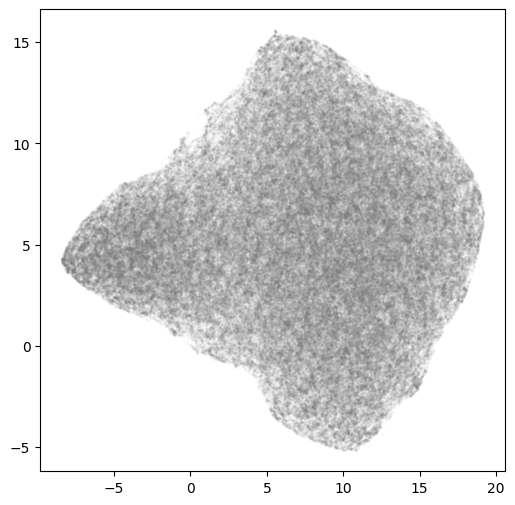

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(u[:,0], u[:,1], s=.1, color="gray", alpha=0.1)

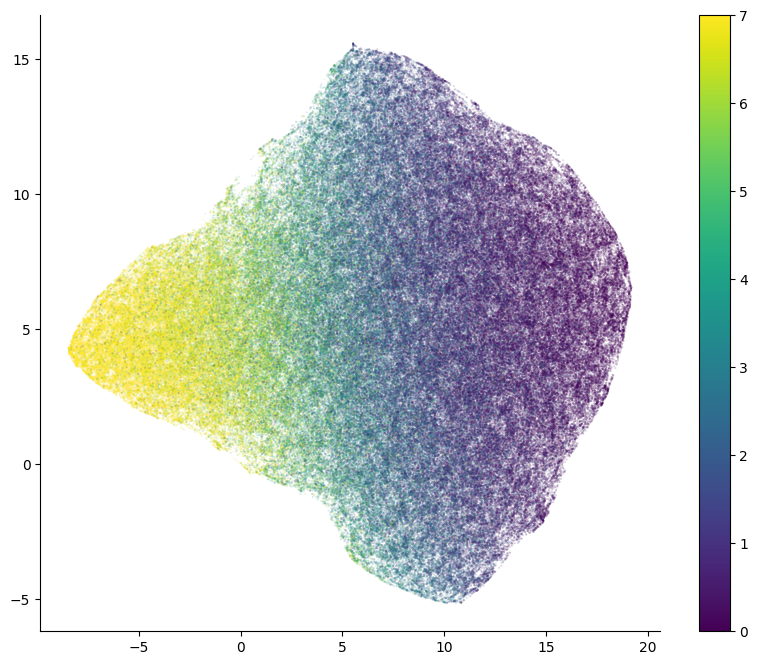

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(u[:,0], u[:,1], s=.1, c = data["nCells"], alpha=0.25)
cbar = plt.colorbar()
cbar.solids.set(alpha=1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [21]:
phyloP = []
with pyBigWig.open("/pi/zhiping.weng-umw/data/andrewsg/phyloP/241-mammalian-2020v2.bigWig") as bw:
    for i in tqdm.trange(len(data)):
        chrom = data.chrom[i]
        start = data.start[i]
        stop = data.stop[i]
        phyloP.append(np.nanmean(bw.values(chrom, start, stop)))

  0%|                                                                                                       | 244/361844 [00:00<07:18, 825.00it/s]/tmp/ipykernel_484679/278594670.py:7: RuntimeWarning: Mean of empty slice
  phyloP.append(np.nanmean(bw.values(chrom, start, stop)))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 361844/361844 [05:52<00:00, 1025.36it/s]


In [22]:
data["phyloP"] = np.nan_to_num(np.array(phyloP))

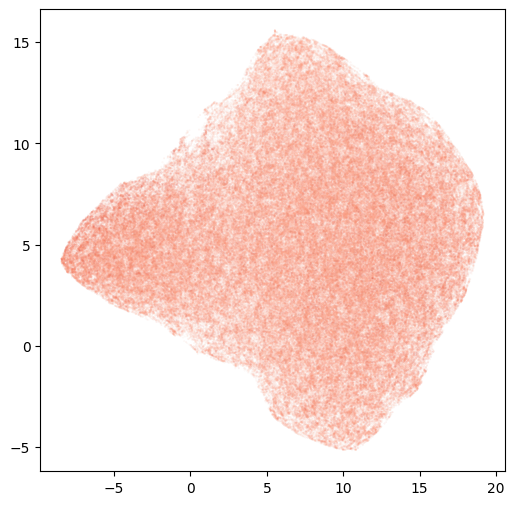

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(u[:,0], u[:,1], s=.1, c=data["phyloP"], alpha=0.1, cmap="Reds")
# ax.scatter(u[indices,0], u[indices,1], s=.1, color="red", alpha=0.1)

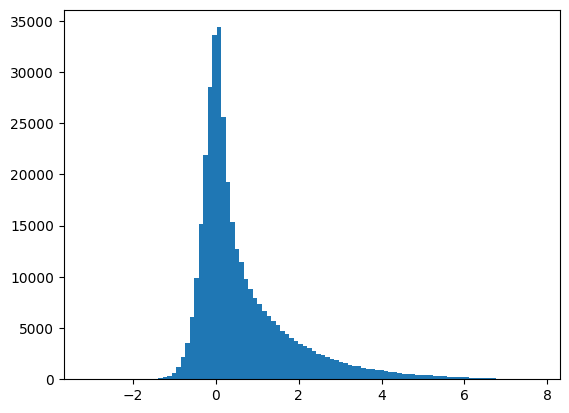

In [24]:
fig, ax = plt.subplots()
_ = ax.hist(phyloP, 100)

In [25]:
genome = Fasta("/home/gregory.andrews-umw/data/genome/hg38.fa", as_raw=True, sequence_always_upper=True)

In [26]:
GC = []
for i in tqdm.trange(len(data)):
    chrom = data.chrom[i]
    start = data.start[i]
    stop = data.stop[i]
    seq = genome[chrom][start:stop]
    l = len(seq)
    C = seq.count("C")
    G = seq.count("G")
    GC.append((C + G) / l)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 361844/361844 [00:10<00:00, 33351.07it/s]


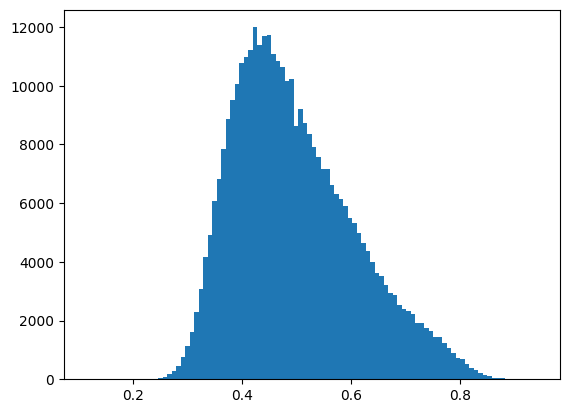

In [27]:
fig, ax = plt.subplots()
_ = ax.hist(GC, 100)

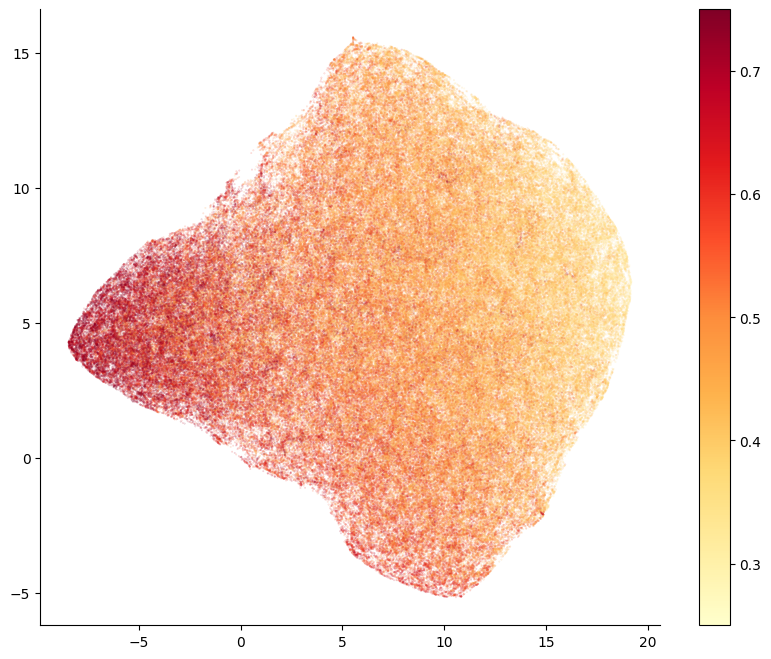

In [28]:
plt.figure(figsize=(10,8))
plt.scatter(u[:,0], u[:,1], s=.1, c = GC, alpha=0.25, vmin=.25, vmax=.75, cmap="YlOrRd")
cbar = plt.colorbar()
cbar.solids.set(alpha=1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [29]:
dTSS = []
closest = Popen(["bedtools", "closest", "-a", bCREs, "-b", "/pi/zhiping.weng-umw/data/andrewsg/TSS.bed", "-d", "-t", "first"], stdout=PIPE)
for line in closest.stdout:
    split = str(line, encoding="utf-8").strip().split("\t")
    dTSS.append(int(split[-1]))
dTSS = np.array(dTSS)

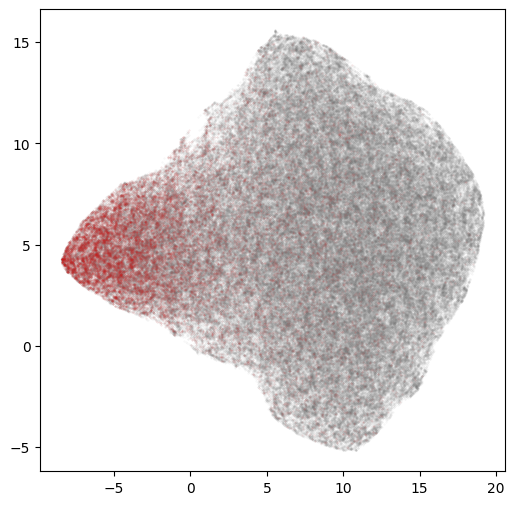

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
indices = np.where(dTSS == 0)
ax.scatter(u[:,0], u[:,1], s=.1, c = "gray", alpha=0.1)
ax.scatter(u[indices,0], u[indices,1], s=.1, color="red", alpha=0.1)

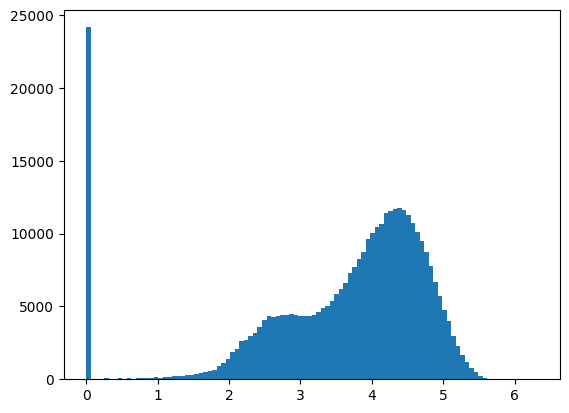

In [31]:
fig, ax = plt.subplots()
_ = ax.hist(np.log10(dTSS+1), 100)

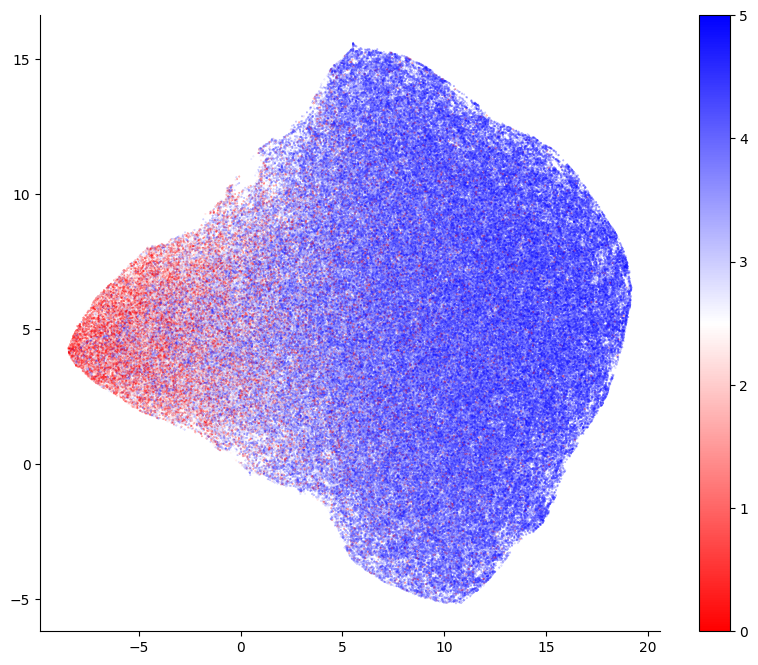

In [32]:
plt.figure(figsize=(10,8))
cmap = matplotlib.colormaps["bwr"].reversed()
plt.scatter(u[:,0], u[:,1], s=.1, c = np.log10(dTSS+1), alpha=0.5, vmin=0, vmax=5, cmap=cmap)
cbar = plt.colorbar()
cbar.solids.set(alpha=1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [33]:
data["GC"] = GC
data["TSS"] = np.log10(dTSS+1)
data["UMAP1"] = u[:,0]
data["UMAP2"] = u[:,1]

In [34]:
data.sort_values("TSS", ascending=False, inplace=True)

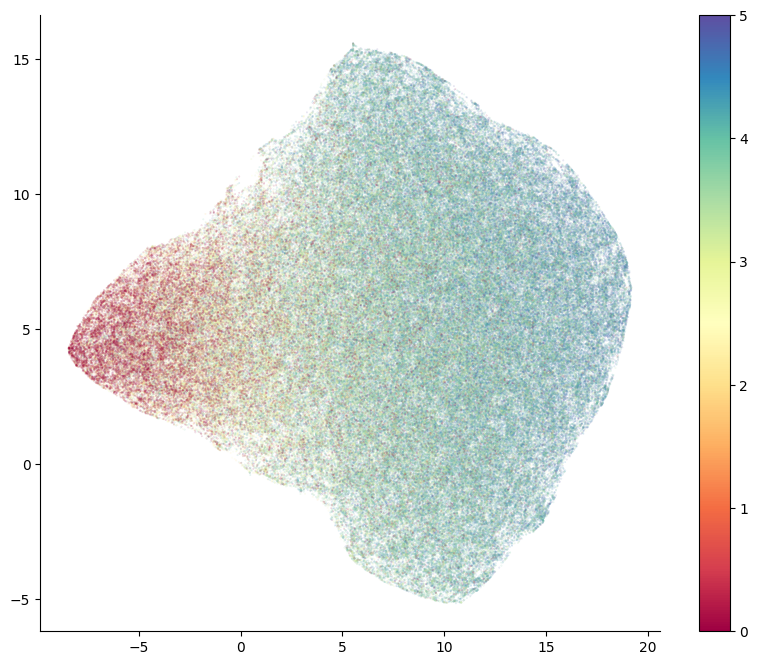

In [35]:
plt.figure(figsize=(10,8))
cmap = matplotlib.colormaps["Spectral"]
plt.scatter(data["UMAP1"], data["UMAP2"], s=.1, c = data["TSS"], alpha=0.2, vmin=0, vmax=5, cmap=cmap)
cbar = plt.colorbar()
cbar.solids.set(alpha=1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)